In [1]:
%%capture
#!pip install datasets pandas matplotlib seaborn --quiet
!pip install -U datasets fsspec --quiet

In [2]:
#Import Libraries
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the IMDB dataset from HuggingFace
dataset = load_dataset("amazon_polarity")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/260M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/258M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/255M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/254M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/117M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3600000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/400000 [00:00<?, ? examples/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 3600000
    })
    test: Dataset({
        features: ['label', 'title', 'content'],
        num_rows: 400000
    })
})

In [6]:
# Convert entire train split (can be big, so here we sample for EDA)
df = dataset['train'].to_pandas()

# Check columns
print(df.columns)

# Preview data
print(df.head())

Index(['label', 'title', 'content'], dtype='object')
   label                                              title  \
0      1                     Stuning even for the non-gamer   
1      1              The best soundtrack ever to anything.   
2      1                                           Amazing!   
3      1                               Excellent Soundtrack   
4      1  Remember, Pull Your Jaw Off The Floor After He...   

                                             content  
0  This sound track was beautiful! It paints the ...  
1  I'm reading a lot of reviews saying that this ...  
2  This soundtrack is my favorite music of all ti...  
3  I truly like this soundtrack and I enjoy video...  
4  If you've played the game, you know how divine...  


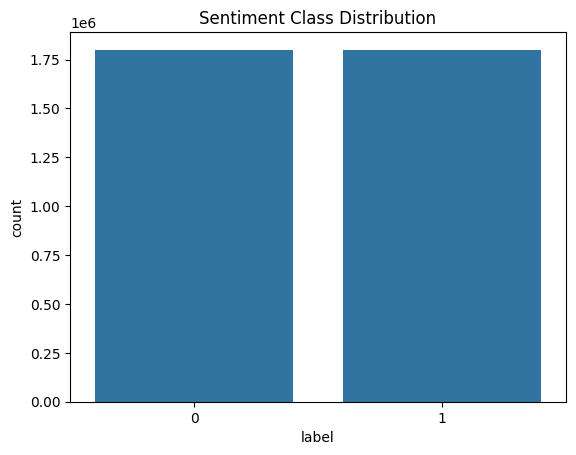

label
1    1800000
0    1800000
Name: count, dtype: int64


In [7]:
# Plot sentiment label counts
sns.countplot(x='label', data=df)
plt.title('Sentiment Class Distribution')
plt.show()

# Print counts
print(df['label'].value_counts())

In [8]:
# Check nulls
print(df.isnull().sum())

label      0
title      0
content    0
dtype: int64


In [9]:
# Check duplicates
print("Duplicate rows:", df.duplicated().sum())

Duplicate rows: 0


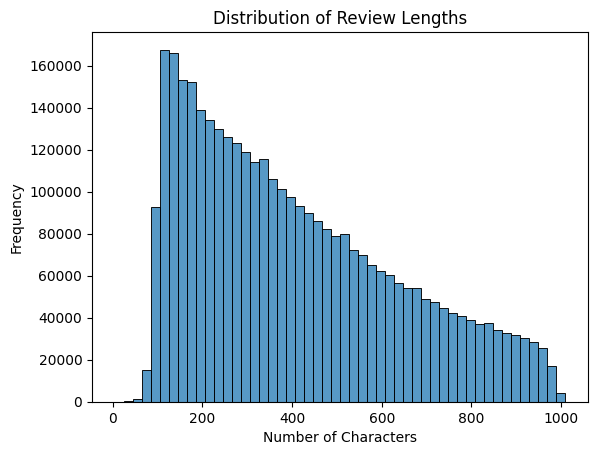

count    3.600000e+06
mean     4.051396e+02
std      2.342711e+02
min      4.000000e+00
25%      2.070000e+02
50%      3.560000e+02
75%      5.660000e+02
max      1.010000e+03
Name: content_length, dtype: float64


In [10]:
# Add length column
df['content_length'] = df['content'].apply(len)

# Plot histogram
sns.histplot(df['content_length'], bins=50)
plt.title('Distribution of Review Lengths')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()

# Print some stats
print(df['content_length'].describe())

Fine Tuning The Model

In [11]:
# Take smaller subsets for speed
train_dataset = dataset["train"].shuffle(seed=42).select(range(10000))
test_dataset = dataset["test"].shuffle(seed=42).select(range(2000))

In [12]:
model_checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [13]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples["content"],
        truncation=True,
        padding='max_length',
        max_length=128
    )

# Tokenize datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [14]:
tokenized_train = tokenized_train.remove_columns(["content", "title"])
tokenized_train = tokenized_train.rename_column("label", "labels")
tokenized_train.set_format("torch")

tokenized_test = tokenized_test.remove_columns(["content", "title"])
tokenized_test = tokenized_test.rename_column("label", "labels")
tokenized_test.set_format("torch")

In [15]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='binary'
    )
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=10,

)

In [20]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-20-3389762461.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zachariasharon (zachariasharon-university-of-hertfordshire) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


KeyboardInterrupt: 

In [ ]:
text = "I loved this product. It works perfectly and exceeded my expectations."

# Tokenize
inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

# Predict
outputs = model(**inputs)
predicted_class = torch.argmax(outputs.logits).item()

# Print result
print("Predicted label:", predicted_class)